In [1]:
!pip install -q ffmpeg-python

In [2]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ffmpeg
from IPython.display import Video
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import logging
from itertools import cycle
from collections import defaultdict
from skimage.color import rgb2hsv, hsv2rgb

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.style.use('ggplot')
cm = sns.light_palette("green", as_cmap=True)
pd.option_context('display.max_colwidth', 100)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
# SEED EVERYTHING
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)

# config
class config:
    BASE_DIR = "/input/tensorflow-great-barrier-reef/train_images/"

In [4]:
img_og = plt.imread('/input/tensorflow-great-barrier-reef/train_images/video_1/9101.jpg')
img_9101 = cv2.imread('/input/tensorflow-great-barrier-reef/train_images/video_1/9101.jpg')

In [5]:
df = pd.read_csv('/input/tensorflow-great-barrier-reef/train.csv')
train_dir = "/input/tensorflow-great-barrier-reef/train_images"
df['image_path'] = train_dir + "/video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"
df.head().style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,0,0,0-0,[],../input/tensorflow-great-barrier-reef/train_images/video_0/0.jpg
1,0,40258,1,1,0-1,[],../input/tensorflow-great-barrier-reef/train_images/video_0/1.jpg
2,0,40258,2,2,0-2,[],../input/tensorflow-great-barrier-reef/train_images/video_0/2.jpg
3,0,40258,3,3,0-3,[],../input/tensorflow-great-barrier-reef/train_images/video_0/3.jpg
4,0,40258,4,4,0-4,[],../input/tensorflow-great-barrier-reef/train_images/video_0/4.jpg


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
 6   image_path      23501 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.3+ MB


In [7]:
df[df.annotations.str.len() > 2].head(5).style.background_gradient(cmap=cm) # filling up the annotation column

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/16.jpg
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/17.jpg
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/18.jpg
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/19.jpg
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/20.jpg


In [8]:
df['annotations'] = df['annotations'].apply(eval)
df_train_v2 = df[df.annotations.str.len() > 0].reset_index(drop=True)
df_train_v2.head(5).style.background_gradient(cmap='Reds')

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/16.jpg
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/17.jpg
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/18.jpg
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/19.jpg
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/20.jpg


In [9]:
df_train_v2["no_of_bbox"] = df_train_v2["annotations"].apply(lambda x: len(x))
df_train_v2["sequence"].value_counts(), len(df_train_v2["sequence"].value_counts())

(8503     1100
 53708     704
 60754     654
 22643     577
 8399      564
 40258     285
 996       209
 59337     156
 45518     123
 60510     113
 17665      87
 35305      80
 15827      74
 18048      71
 29859      71
 26651      29
 45015      22
 Name: sequence, dtype: int64,
 17)

In [10]:
for i in range(3):
    print(df_train_v2["sequence"][df_train_v2["video_id"] == i].unique(),
          df_train_v2["sequence"][df_train_v2["video_id"] == i].nunique())

[40258 45518 59337  8399 45015 35305 53708   996] 8
[60510 15827  8503 18048 17665 60754] 6
[26651 22643 29859] 3


In [11]:
def plot_with_count(df, vid):
    names = df["bbox_typ"].to_list()
    values = df["counts"].to_list()
    N = len(names)
    menMeans = values
    ind = np.arange(N)
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(ind, menMeans, width=0.4)
    plt.xticks(np.arange(0, N, step=1))
    plt.title(f"Number of bounding box VS Count of Bounding Box: Video {vid}", fontsize=20)
    plt.xlabel('Number of bounding box', fontsize=18)
    plt.ylabel('Count', fontsize=16)
    for index, data in enumerate(menMeans):
        plt.text(x=index, y=data+1, s=f"{data}", fontdict=dict(fontsize=15))

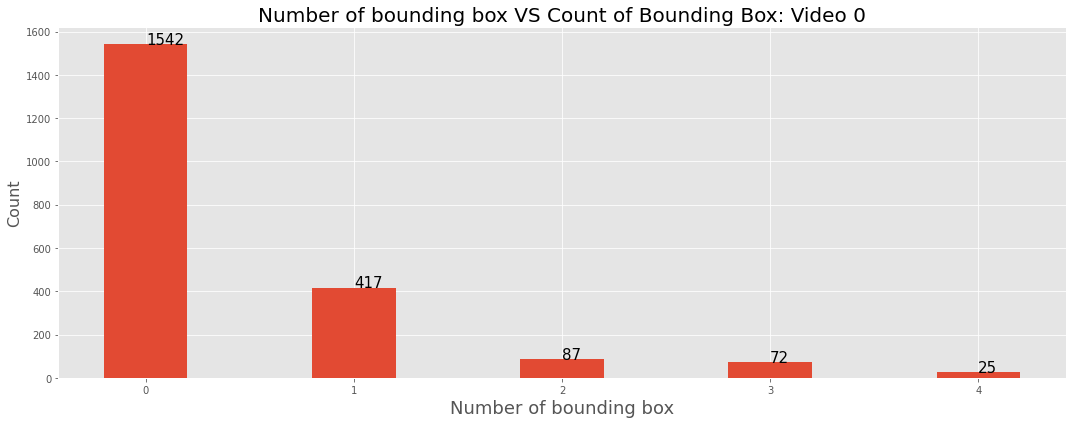

In [12]:
vid = 0
df_vod0_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index()
df_vod0_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod0_bbox_cnt, vid)

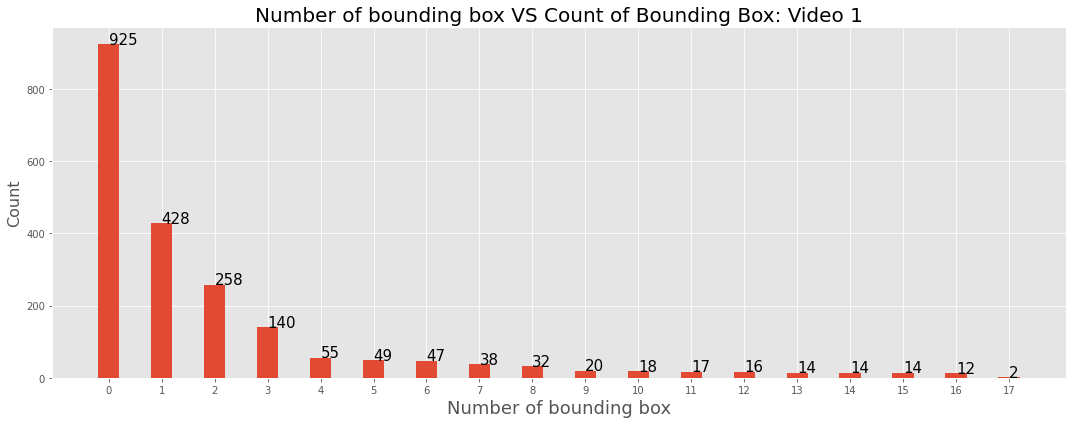

In [13]:
vid = 1
df_vod1_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index()
df_vod1_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod1_bbox_cnt, vid)

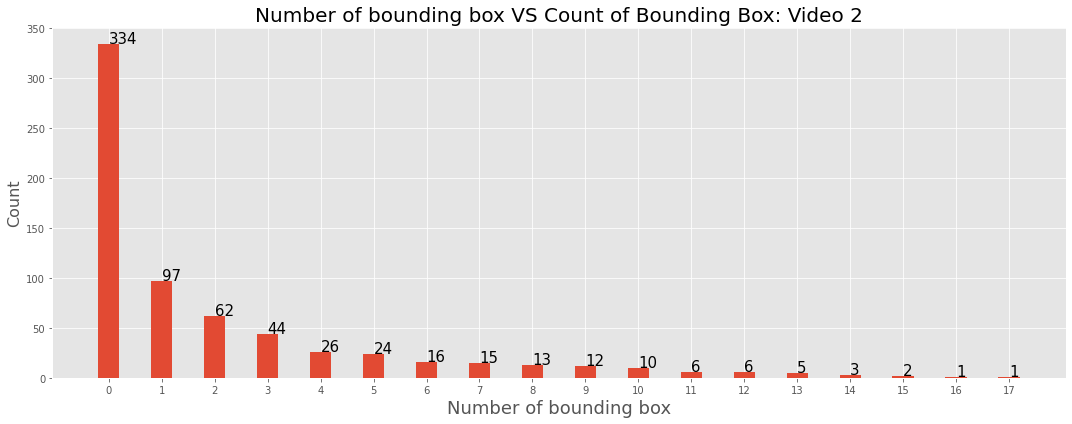

In [14]:
vid = 2
df_vod2_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index()
df_vod2_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod2_bbox_cnt, vid)

In [15]:
df = pd.read_csv("/input/tensorflow-great-barrier-reef/train.csv")
df['annotations'] = df['annotations'].apply(eval)
df['n_annotations'] = df['annotations'].str.len()
df['has_annotations'] = df['annotations'].str.len() > 0
df['has_2_or_more_annotations'] = df['annotations'].str.len() >= 2
df['doesnt_have_annotations'] = df['annotations'].str.len() == 0
df['image_path'] = config.BASE_DIR + "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

In [16]:
df_agg = df.groupby(["video_id", 'sequence']).agg({'sequence_frame': 'count', 'has_annotations': 'sum', 'doesnt_have_annotations': 'sum'})\
           .rename(columns={'sequence_frame': 'Total Frames', 'has_annotations': 'Frames with at least 1 object', 'doesnt_have_annotations': "Frames with no object"})
df_agg

Total Frames  Frames with at least 1 object  \
video_id sequence                                                
0        996                923                            209   
         8399              1423                            564   
         35305              853                             80   
         40258              480                            285   
         45015              617                             22   
         45518              798                            123   
         53708             1077                            704   
         59337              537                            156   
1        8503              2843                           1100   
         15827              770                             74   
         17665               87                             87   
         18048               71                             71   
         29424              184                              0   
         44160              151                              0   
         60510             1167                            113   
         60754             2959                            654   
2        22643             1248                            577   
         26651             1525                             29   
         29859             2988                             71   
         37114             2800                              0   

                   Frames with no object  
video_id sequence                         
0        996                         714  
         8399                        859  
         35305                       773  
         40258                       195  
         45015                       595  
         45518                       675  
         53708                       373  
         59337                       381  
1        8503                       1743  
         15827                       696  
         17665                         0  
         18048                         0  
         29424                       184  
         44160                       151  
         60510                      1054  
         60754                      2305  
2        22643                       671  
         26651                      1496  
         29859                      2917  
         37114                      2800

In [17]:
def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))
    return sceneRadiance

dest_path1 = "./clahe_img"
os.mkdir(dest_path1)

for img_path in tqdm(df_train_v2["image_path"][0:400]):
    image = plt.imread(img_path)
    image_cv = cv2.imread(img_path)
    img_clahe = RecoverCLAHE(image_cv)
    file_name = img_path.split("/")[-1]
    cv2.imwrite(dest_path1+"/"+file_name, img_clahe)

100%|██████████| 400/400 [00:32<00:00, 12.29it/s]


In [18]:
dest_path1 = "./annot_img"
os.mkdir(dest_path1)

idx = 0
for img_idx in tqdm(df_train_v2["image_path"][0:400]):
    file_name = img_idx.split("/")[-1]
    img_path = os.path.join("./clahe_img", file_name)
    image = plt.imread(img_path)
    for i in range(len(df_train_v2["annotations"][idx])):
        file_name = img_path.split('/')[-1]
        b_boxs = df_train_v2["annotations"][idx][i]
        x, y, w, h = b_boxs["x"], b_boxs["y"], b_boxs["width"], b_boxs["height"]
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        image = cv2.putText(image, 'starfish', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.imwrite(dest_path1+"/"+file_name, image)
    idx += 1

100%|██████████| 400/400 [00:15<00:00, 25.23it/s]


<Figure size 864x1080 with 0 Axes>

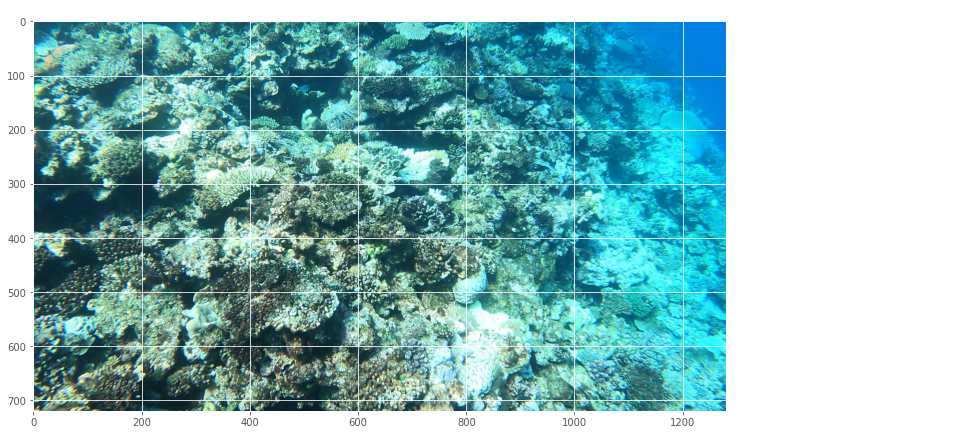

In [19]:
plt.figure(figsize=(12,15))
plt.rcParams["figure.figsize"] = [20.00, 10.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(figsize=(20,6))
ax.imshow(plt.imread("/input/tensorflow-great-barrier-reef/train_images/video_0/40.jpg"))
newax = fig.add_axes([0.3,0.3,0.6,0.7], anchor='NE', zorder=1)
newax.axis('off')
plt.show()

In [ ]:
img_sizes = []
for i in df_train_v2["image_path"]:
    img_sizes.append(plt.imread(i).shape)
np.unique(img_sizes)

In [ ]:
len(df_train_v2)

In [ ]:
plt.figure(figsize=(12,15))
plt.rcParams["figure.figsize"] = [20.00, 10.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(figsize=(20,6))
ax.imshow(plt.imread("./annot_img/40.jpg"))
newax = fig.add_axes([0.26,0.2,0.6,0.6], anchor='NE', zorder=1)
#newax.imshow(im)
newax.axis('off')
plt.show()

In [ ]:
count_bbox = []
for i in df["annotations"]:
    count_bbox.append(len(i))

bbox_dict = defaultdict(int)
for val in count_bbox:
    bbox_dict[val] += 1

names = list(bbox_dict.keys())
values = list(bbox_dict.values())
N = len(list(bbox_dict.values()))
menMeans = list(bbox_dict.values())
ind = np.arange(N)
plt.rcParams["figure.figsize"] = [20.00, 10.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(ind, menMeans, width=0.4)
plt.xticks(np.arange(0, N, step=1))
plt.title("Number of bounding box VS Count of Bounding Box", fontsize=20)
plt.xlabel('Number of bounding box', fontsize=18)
plt.ylabel('Count', fontsize=16)
for index, data in enumerate(menMeans):
    plt.text(x=index, y=data+1, s=f"{data}", fontdict=dict(fontsize=20))
newax = fig.add_axes([0.3,0.35,0.6,0.5], anchor='NE', zorder=1)
#newax.imshow(im)
newax.axis('off')
plt.show()

In [ ]:
def he_hsv(img_demo):
    img_hsv = cv2.cvtColor(img_demo, cv2.COLOR_RGB2HSV)
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    image_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return image_hsv

In [ ]:
def plot_img(img_dir, num_items, func, mode):
    img_list = random.sample(os.listdir(img_dir), num_items)
    for i in range(len(img_list)):
        full_path = img_dir + '/' + img_list[i]
        img_temp1 = plt.imread(full_path)
        img_temp_cv = cv2.imread(full_path)
        plt.figure(figsize=(20,15))
        plt.subplot(1,2,1)
        plt.imshow(img_temp1)
        plt.subplot(1,2,2)
        if mode == 'plt':
            plt.imshow(func(img_temp1))
        elif mode == 'cv2':
            plt.imshow(func(img_temp_cv))

In [ ]:
vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 5
plot_img(vid_0_dir, num_items1, he_hsv, "plt")

In [ ]:
def RecoverHE(sceneRadiance):
    for i in range(3):
        sceneRadiance[:, :, i] = cv2.equalizeHist(sceneRadiance[:, :, i])
    return sceneRadiance

vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 4
plot_img(vid_0_dir, num_items1, RecoverHE, "cv2")

In [ ]:
def clahe_hsv(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(20,20))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb

vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 4
plot_img(vid_0_dir, num_items1, clahe_hsv, "cv2")

In [ ]:
def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))
    return sceneRadiance

vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 4
plot_img(vid_0_dir, num_items1, RecoverCLAHE, "cv2")

In [ ]:
def gamma_enhancement(image, gamma):
    R = 255.0
    return (R * np.power(image.astype(np.uint32)/R, gamma)).astype(np.uint8)

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.imshow(img_og)
plt.subplot(2,2,2)
plt.imshow(gamma_enhancement(img_9101, 1/0.6))
plt.subplot(2,2,3)
plt.imshow(img_og)
plt.subplot(2,2,4)
plt.imshow(gamma_enhancement(img_og, 1/0.6))

In [ ]:
def RecoverGC(sceneRadiance):
    sceneRadiance = sceneRadiance/255.0
    for i in range(3):
        sceneRadiance[:, :, i] = np.power(sceneRadiance[:, :, i] / float(np.max(sceneRadiance[:, :, i])), 3.2)
    sceneRadiance = np.clip(sceneRadiance*255, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance

vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 4
plot_img(vid_0_dir, num_items1, RecoverGC, "cv2")

In [ ]:
def global_stretching(img_L, height, width):
    I_min = np.min(img_L)
    I_max = np.max(img_L)
    I_mean = np.mean(img_L)
    array_Global_histogram_stretching_L = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            p_out = (img_L[i][j] - I_min) * ((1) / (I_max - I_min))
            array_Global_histogram_stretching_L[i][j] = p_out
    return array_Global_histogram_stretching_L

def stretching(img):
    height = len(img)
    width = len(img[0])
    for k in range(0, 3):
        Max_channel = np.max(img[:,:,k])
        Min_channel = np.min(img[:,:,k])
        for i in range(height):
            for j in range(width):
                img[i,j,k] = (img[i,j,k] - Min_channel) * (255 - 0) / (Max_channel - Min_channel) + 0
    return img

def HSVStretching(sceneRadiance):
    height = len(sceneRadiance)
    width = len(sceneRadiance[0])
    img_hsv = rgb2hsv(sceneRadiance)
    h, s, v = cv2.split(img_hsv)
    img_s_stretching = global_stretching(s, height, width)
    img_v_stretching = global_stretching(v, height, width)
    labArray = np.zeros((height, width, 3), 'float64')
    labArray[:, :, 0] = h
    labArray[:, :, 1] = img_s_stretching
    labArray[:, :, 2] = img_v_stretching
    img_rgb = hsv2rgb(labArray) * 255
    return img_rgb

def sceneRadianceRGB(sceneRadiance):
    sceneRadiance = np.clip(sceneRadiance, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance

In [ ]:
def RecoverICM(img1):
    img = stretching(img1)
    sceneRadiance = sceneRadianceRGB(img)
    sceneRadiance = HSVStretching(sceneRadiance)
    sceneRadiance = sceneRadianceRGB(sceneRadiance)
    return sceneRadiance

vid_0_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items1 = 4
plot_img(vid_0_dir, num_items1, RecoverICM, "cv2")

In [ ]:
def plot_img_tf(img_dir, num_items, func, mode):
    img_list = random.sample(os.listdir(img_dir), num_items)
    full_path = img_dir + '/' + img_list[0]
    img_temp_plt = plt.imread(full_path)
    img_temp_cv = cv2.imread(full_path)
    if mode == "plt":
        img_stack = np.hstack((img_temp_plt, func(img_temp_plt)))
        plt.figure(figsize=(20,15))
        plt.imshow(img_stack)
        plt.title("Original Image VS Enhanced Image", fontsize=25)
        plt.axis("off")
        plt.show()
    if mode == "cv2":
        img_stack = np.hstack((img_temp_cv, func(img_temp_cv)))
        plt.figure(figsize=(20,15))
        plt.imshow(img_stack)
        plt.title("Original Image VS Enhanced Image", fontsize=25)
        plt.axis("off")
        plt.show()
    for i in range(1, len(img_list)):
        full_path = img_dir + '/' + img_list[i]
        img_temp_plt = plt.imread(full_path)
        img_temp_cv = cv2.imread(full_path)
        if mode == "plt":
            img_stack = np.hstack((img_temp_plt, func(img_temp_plt)))
            plt.figure(figsize=(20,15))
            plt.imshow(img_stack)
            plt.axis("off")
            plt.show()
        if mode == "cv2":
            img_stack = np.hstack((img_temp_cv, func(img_temp_cv)))
            plt.figure(figsize=(20,15))
            plt.imshow(img_stack)
            plt.axis("off")
            plt.show()

img_dir = "/input/tensorflow-great-barrier-reef/train_images/video_0"
num_items = 4
plot_img_tf(img_dir, num_items, tfa.image.equalize, "plt")

In [ ]:
(
    ffmpeg.input('./clahe_img/*.jpg', pattern_type='glob', framerate=1.667)
    .output('img_movie.mp4')
    .run()
)

In [ ]:
(
    ffmpeg.input('./annot_img/*.jpg', pattern_type='glob', framerate=1.667)
    .output('annot_movie.mp4')
    .run()
)

In [ ]:
Video("./img_movie.mp4")


In [ ]:
Video("./annot_movie.mp4")